In [59]:
import numpy as np
import matplotlib.pyplot as plt
import re
import low_rank_MPLN
import pandas as pd

In [60]:
# Functions to extract relevant values from the simulations
def extract_B(model):
    B = model.B[:,2].detach().numpy().flatten()
    return B

def extract_Sigma(model):
    Sigma = low_rank_MPLN.compute_Sigma(model.V.numpy(), model.a.detach().numpy())
    return Sigma

# Errors and Biases elative errors
def compute_bias(B_est, B_true):
    bias = np.mean(B_est-B_true, axis=1)
    mean_abs_bias = np.mean(np.abs(bias))
    return (bias, mean_abs_bias)

# Returns the average relative error (frobenius norm / l2 norm for matrix / vectors), summed over the outermost index
def compute_relative_errors(est, true, vector=True):
    if vector:
        errors = np.linalg.norm(est-true, axis=1) / np.linalg.norm(true, axis=1)
    else:
        errors = np.linalg.norm(est-true, "fro", axis=(1,2)) / np.linalg.norm(true, "fro", axis=(1,2))

    return errors, np.mean(errors)



def extract_from_sim(sim_name, sim_path):
    B_est = []
    B_true = []
    Sigma_est = []
    Sigma_true = []
    for sim_iter in range(100):
        model_true, _ = low_rank_MPLN.load_model_fit(sim_name + "_true", sim_iter=0, sim_path=sim_path, load_model=True, load_fit=False)
        model, _ = low_rank_MPLN.load_model_fit(sim_name, sim_iter=sim_iter, sim_path=sim_path, load_model=True, load_fit=True)
        B_true.append(extract_B(model_true))
        B_est.append(extract_B(model))
        Sigma_true.append(extract_Sigma(model_true))
        Sigma_est.append(extract_Sigma(model))
    B_true = np.stack(B_true)
    B_est = np.stack(B_est)
    Sigma_true = np.stack(Sigma_true)
    Sigma_est = np.stack(Sigma_est)

    return {
        'B_est': B_est,
        'B_true': B_true,
        'Sigma_est': Sigma_est,
        'Sigma_true': Sigma_true
    }


def parse_sim_name(sim_name):
    sim_setting = {'n': int(sim_name.split('_')[1][1:]),
                'p': int(sim_name.split('_')[2][1:]),
                'q': int(sim_name.split('_')[3][1:])}
    return(sim_setting)

    
def plot_B_est(B_est, sim_name):
    # Get the sim setting from the name
    # Extract values using regular expression
    matches = re.search(r'n(\d+)_p(\d+)_q(\d+)', sim_name)
    n_val, p_val, q_val = matches.groups()
    

    # Format the extracted values into the desired string

    plt.boxplot(B_est)
    plt.title(f'n = {n_val}, p = {p_val}, q = {q_val}')
    plt.xlabel("B2 coefficients")
    plt.xticks([])
    plt.axhline(y=0, color="red", ls="dotted", lw=0.5)
    plt.axhline(y=0.8, color="red", ls="dotted", lw=0.5)
    plt.axhline(y=0.2, color="red", ls="dotted", lw=0.5)
    plt.axhline(y=0.1, color="red", ls="dotted", lw=0.5)
    plt.axhline(y=-0.1, color="red", ls="dotted", lw=0.5)
    plt.show()

In [61]:
sim_path = "sim31/"

sim_names = [
    "sim31_n5000_p100_q20",
    "sim31_n5000_p200_q20",
    "sim31_n5000_p400_q20",
    "sim31_n10000_p100_q20",
    "sim31_n10000_p200_q20"
    # "sim31_n10000_p400_q20"
]
# We extract all the simulation results of interest
sims = {sim_name: extract_from_sim(sim_name, sim_path) for sim_name in sim_names}

In [62]:
# Compute relative errors and (absolute) biases
B_relative_errors = {sim_name: compute_relative_errors(sim['B_est'], sim['B_true'], vector=True)[1] for sim_name, sim in sims.items()}
Sigma_relative_errors = {sim_name: compute_relative_errors(sim['Sigma_est'], sim['Sigma_true'], vector=False)[1] for sim_name, sim in sims.items()}
B_bias = {sim_name: compute_bias(sim['B_est'], sim['B_true'])[1] for sim_name, sim in sims.items()}

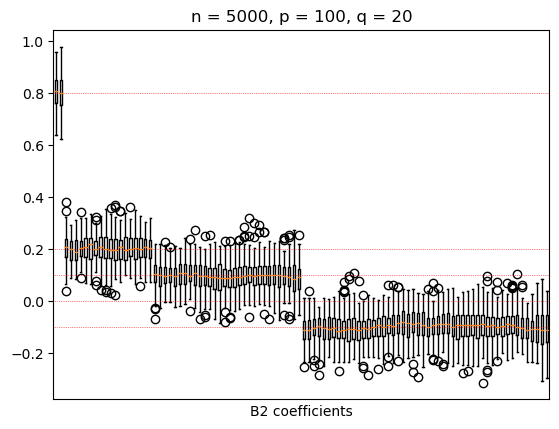

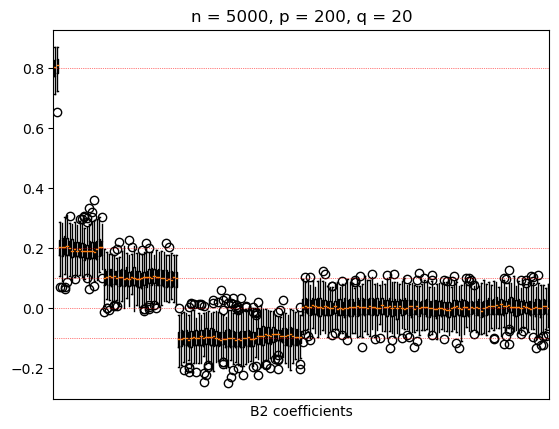

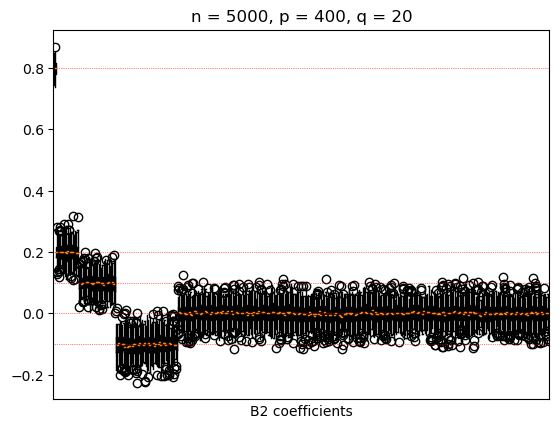

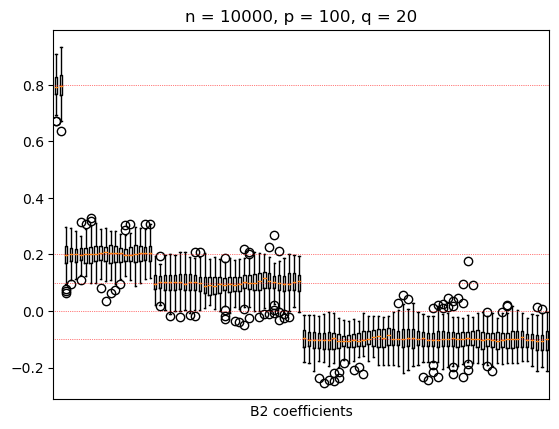

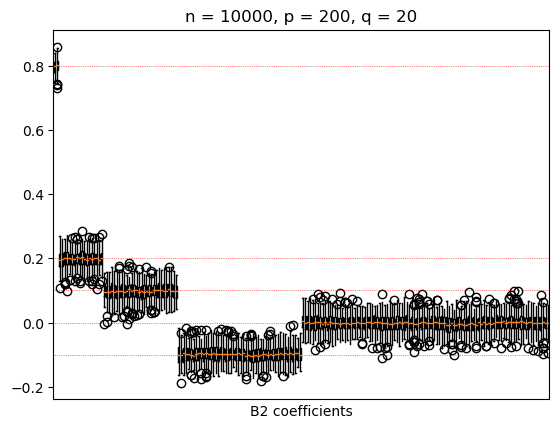

In [63]:
for sim_name, sim in sims.items():
    plot_B_est(sim['B_est'], sim_name)

In [64]:
Sigma_relative_errors

{'sim31_n5000_p100_q20': 0.014967092,
 'sim31_n5000_p200_q20': 0.012590086,
 'sim31_n5000_p400_q20': 0.011973151,
 'sim31_n10000_p100_q20': 0.01073138,
 'sim31_n10000_p200_q20': 0.008926554}

In [65]:
B_relative_errors

{'sim31_n5000_p100_q20': 0.3366951,
 'sim31_n5000_p200_q20': 0.31494027,
 'sim31_n5000_p400_q20': 0.36345303,
 'sim31_n10000_p100_q20': 0.2394378,
 'sim31_n10000_p200_q20': 0.22363682}

In [41]:
# Extracting the values for the columns 'n', 'p', 'q' from the dictionary keys
parse_sim_name(list(Sigma_relative_errors.keys())[0])


{'n': 5000, 'p': 100, 'q': 20}

We notice no systematic bias.